In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/content'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/content/train_identity.csv
/content/test_identity.csv
/content/train_transaction.csv
/content/test_transaction.csv
/content/.config/gce
/content/.config/config_sentinel
/content/.config/.last_update_check.json
/content/.config/active_config
/content/.config/.metricsUUID
/content/.config/configurations/config_default
/content/.config/logs/2019.08.27/16.17.17.407104.log
/content/.config/logs/2019.08.27/16.17.22.686467.log
/content/.config/logs/2019.08.27/16.17.00.530950.log
/content/.config/logs/2019.08.27/16.17.07.367707.log
/content/.config/logs/2019.08.27/16.17.21.663235.log
/content/sample_data/README.md
/content/sample_data/anscombe.json
/content/sample_data/california_housing_test.csv
/content/sample_data/mnist_test.csv
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_train_small.csv


In [0]:
# load the train and test data
train_identity = pd.read_csv("train_identity.csv")
train_transaction = pd.read_csv("train_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")
test_transaction = pd.read_csv("test_transaction.csv")

In [0]:
# reduce your memory by conversion
# convert it to the low memory to fit the RAM
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
#merge both the transaction and identity by left
train = pd.merge(train_transaction,train_identity,how="left",on="TransactionID")
test = pd.merge(test_transaction,test_identity,how="left",on="TransactionID")

In [5]:
#now we should reduce the memory to free the RAM or else we cant fit the model
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)


In [0]:
# delete the 4 variables in order to reduce the memory issue
del train_identity
del test_identity
del train_transaction
del test_transaction

In [7]:
#Try to explore  all the columns in your dataframe
train.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [8]:
# category columns
category_column = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9',
            'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']
print("no of categorical column:",len(category_column))

no of categorical column: 55


In [9]:
#let us try to check for NAs in each columns
print("Train data")
train.isna().sum()
print("Test data")
test.isna().sum()

Train data
Test data


TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8654
card3               3002
card4               3086
card5               4547
card6               3007
addr1              65609
addr2              65609
dist1             291217
dist2             470255
P_emaildomain      69192
R_emaildomain     370821
C1                     3
C2                     3
C3                     3
C4                     3
C5                     3
C6                     3
C7                     3
C8                     3
C9                     3
C10                    3
C11                    3
C12                    3
C13                 4748
C14                    3
                   ...  
id_11             369913
id_12             364784
id_13             376405
id_14             435334
id_15             369714
id_16             380944
id_17             370725
id_18             455816
id_19             370785


In [0]:
#EDA
#If there is more than 90% NA's we can remove that no need of that column it was not going to affect that much on the final column
more_than_90_NA_or_same_value_train = []
more_than_90_NA_or_same_value_test = []
many_na_train = []
many_na_test = []
for col in train.columns:
    if train[col].isna().sum()/train.shape[0] >= 0.90:
        many_na_train.append(col) # full of NAs in train
for col in test.columns:
    if test[col].isna().sum()/test.shape[0] >= 0.90:
        many_na_test.append(col) # full of NAs in test
for col in train.columns:
  #  print(col,train[col].value_counts(dropna=False,normalize=True).values[0])
    if train[col].value_counts(dropna=False,normalize=True).values[0] >= 0.90:
      #  print("More than 90% is NA's or same value so we can delete that columns")
        more_than_90_NA_or_same_value_train.append(col) # more unique values in train
for col in test.columns:
    if test[col].value_counts(dropna=False,normalize=True).values[0] >= 0.90:
        more_than_90_NA_or_same_value_test.append(col) #more unique values in test

In [12]:
# store the columns to be dropped separately in train and test
cols_drop_at_train = list(set(more_than_90_NA_or_same_value_train+many_na_train))
cols_drop_at_test = list(set(more_than_90_NA_or_same_value_test+many_na_test))
print("Columns to be dropped in train",len(cols_drop_at_train))
print("Columns to be dropped in test",len(cols_drop_at_test))
print("columns are @ train:",cols_drop_at_train)
print("columns are @ test:", cols_drop_at_train)

Columns to be dropped in train 67
Columns to be dropped in test 79
columns are @ train: ['V123', 'V124', 'V297', 'V105', 'V112', 'id_07', 'C3', 'V113', 'D7', 'V137', 'V98', 'V320', 'id_24', 'V300', 'V286', 'V316', 'V318', 'V114', 'V107', 'id_25', 'dist2', 'V121', 'V299', 'V319', 'isFraud', 'V296', 'V116', 'V321', 'V293', 'V104', 'V301', 'V103', 'V119', 'id_23', 'V290', 'V135', 'V111', 'V108', 'V120', 'V305', 'id_18', 'V136', 'V117', 'V129', 'V295', 'V298', 'V102', 'V106', 'V125', 'id_27', 'V118', 'id_22', 'V122', 'V115', 'V309', 'V109', 'V311', 'V110', 'id_26', 'id_21', 'V132', 'V133', 'V101', 'V281', 'id_08', 'V134', 'V284']
columns are @ test: ['V123', 'V124', 'V297', 'V105', 'V112', 'id_07', 'C3', 'V113', 'D7', 'V137', 'V98', 'V320', 'id_24', 'V300', 'V286', 'V316', 'V318', 'V114', 'V107', 'id_25', 'dist2', 'V121', 'V299', 'V319', 'isFraud', 'V296', 'V116', 'V321', 'V293', 'V104', 'V301', 'V103', 'V119', 'id_23', 'V290', 'V135', 'V111', 'V108', 'V120', 'V305', 'id_18', 'V136', 'V117

In [14]:
total_drop_cols = list(set(cols_drop_at_train+cols_drop_at_test))
print("Total no of columns to be deleted to increase your model performance",len(total_drop_cols))
print("They are:",total_drop_cols)

Total no of columns to be deleted to increase your model performance 83
They are: ['V123', 'V124', 'V297', 'V105', 'V112', 'id_07', 'C3', 'V113', 'D7', 'V137', 'V98', 'V320', 'id_24', 'V300', 'V66', 'V286', 'V316', 'V23', 'V318', 'V14', 'V114', 'V107', 'id_25', 'dist2', 'V121', 'V299', 'V319', 'isFraud', 'V296', 'V65', 'V116', 'V321', 'V293', 'V104', 'V25', 'V301', 'V103', 'V119', 'V67', 'V88', 'V89', 'id_23', 'V290', 'V135', 'V111', 'V108', 'V120', 'V305', 'id_18', 'V26', 'V136', 'V68', 'V117', 'V129', 'V295', 'V298', 'V86', 'V102', 'V77', 'V106', 'V125', 'id_27', 'V118', 'id_22', 'V122', 'V115', 'V309', 'V24', 'V109', 'V55', 'V311', 'V110', 'V27', 'id_26', 'id_21', 'V132', 'V28', 'V133', 'V101', 'V281', 'id_08', 'V134', 'V284']


In [15]:
# remove the isFraud
total_drop_cols.remove('isFraud')
print("You can check thta column is removed:",total_drop_cols)

You can check thta column is removed: ['V123', 'V124', 'V297', 'V105', 'V112', 'id_07', 'C3', 'V113', 'D7', 'V137', 'V98', 'V320', 'id_24', 'V300', 'V66', 'V286', 'V316', 'V23', 'V318', 'V14', 'V114', 'V107', 'id_25', 'dist2', 'V121', 'V299', 'V319', 'V296', 'V65', 'V116', 'V321', 'V293', 'V104', 'V25', 'V301', 'V103', 'V119', 'V67', 'V88', 'V89', 'id_23', 'V290', 'V135', 'V111', 'V108', 'V120', 'V305', 'id_18', 'V26', 'V136', 'V68', 'V117', 'V129', 'V295', 'V298', 'V86', 'V102', 'V77', 'V106', 'V125', 'id_27', 'V118', 'id_22', 'V122', 'V115', 'V309', 'V24', 'V109', 'V55', 'V311', 'V110', 'V27', 'id_26', 'id_21', 'V132', 'V28', 'V133', 'V101', 'V281', 'id_08', 'V134', 'V284']


In [0]:
for col in total_drop_cols:
    if col not in train.columns:
        print("missing drop column in train",col)
    if col not in test.columns:
        print("Missing drop columns in test",col)

In [18]:
n = 0
print("len",len(total_drop_cols))
for col in train.columns:
    if col in total_drop_cols:
        n += 1
print(n)

len 82
82


In [19]:
#columns after dropping unwanted columns
print("Total no of columns we have now",len(train.columns))

Total no of columns we have now 434


Text(0, 0.5, 'Counts')

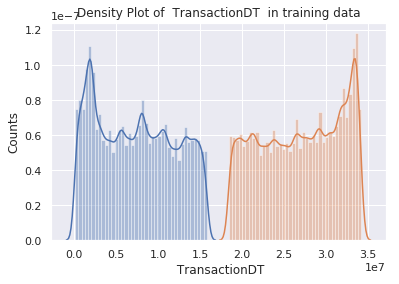

In [20]:
# after dropping columns we need to explore the data distrubtions
# try to plot the distribution to check it
# reference:https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0
# we can start to analyze from the  TransactionDT
# timedelta from a given reference datetime (not an actual timestamp)
sns.distplot(train['TransactionDT'], hist=True, kde=True,bins=40) # its shows histogram along with the density plot
sns.distplot(test['TransactionDT'],hist=True,kde=True,bins=40)

plt.title('Density Plot of  TransactionDT  in training data')
plt.xlabel(' TransactionDT')
plt.ylabel('Counts')

Text(0, 0.5, 'Counts')

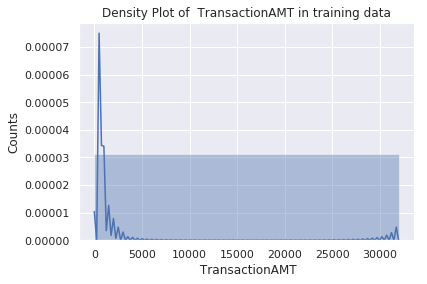

In [21]:
#TransactionAMT: transaction payment amount in USD
sns.distplot(train['TransactionAmt'], hist=True, kde=True,bins=1) # its shows histogram along with the density plot

plt.title('Density Plot of  TransactionAMT in training data')
plt.xlabel(' TransactionAMT')
plt.ylabel('Counts')
# most of the amount is less than 5000

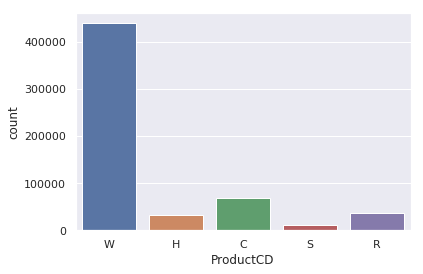

In [22]:
#ProductCD --  product code, the product for each transaction
#sns.catplot(x="index", y="ProductCD", hue="index", kind="bar", data=feature_count); 
# in the above plot we can arrange it
sns.countplot(x="ProductCD", data=train) # shows the count in each class

In [24]:
# how we can start to analyze more about the cards
#card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
# categorical variable -ALL the cards
for col in ['card1','card2','card3','card4','card5','card6']:
    print("Feature count of " + str(col))
    feature_count = (train[col].value_counts())
    print(feature_count.head(2)) # its so big so i have plotted only 2 
# card1- some numerical values
#card2- some amount with float values
#card3- same as card 2
#card4 - card type- [visa,mastercard,american express,discover]
#card5- same as card2
#card6- type of the card-[debit,credit,charge card,debit or credit]

Feature count of card1
7919    14932
9500    14162
Name: card1, dtype: int64
Feature count of card2
321.0    48935
111.0    45191
Name: card2, dtype: int64
Feature count of card3
150.0    521287
185.0     56346
Name: card3, dtype: int64
Feature count of card4
visa          384767
mastercard    189217
Name: card4, dtype: int64
Feature count of card5
226.0    296546
224.0     81513
Name: card5, dtype: int64
Feature count of card6
debit     439938
credit    148986
Name: card6, dtype: int64


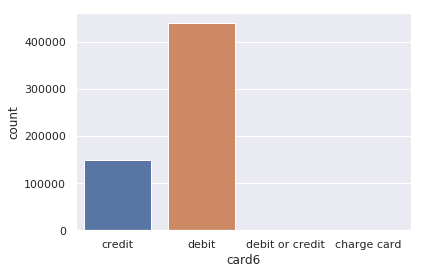

In [25]:
# card 6-type of card
sns.countplot(x=train['card6'])

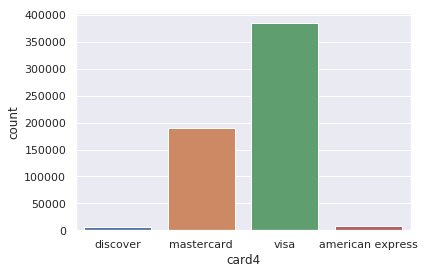

In [26]:
#card4-types of card
sns.countplot(train['card4'])

In [27]:
# how we can start to check how many transaction amount are in each types of card
#for the sum it shows infifnite
print(train.groupby('card4')['TransactionAmt'].mean()) # the discover has highest mean over all

card4
american express    173.000
discover            265.750
mastercard          132.375
visa                133.125
Name: TransactionAmt, dtype: float16


In [28]:
# we can now check for card6
print(train.groupby('card6')['TransactionAmt'].mean()) # the discover has highest mean over all
#fig, ax = plt.subplots()
#train.groupby('card6').plot(x='card6', y='TransactionAmt',ax=ax)
# credit card has more value

card6
charge card         59.53125
credit             190.00000
debit              116.31250
debit or credit    104.06250
Name: TransactionAmt, dtype: float16


This column has high number of categoricals to print so it will be very slow


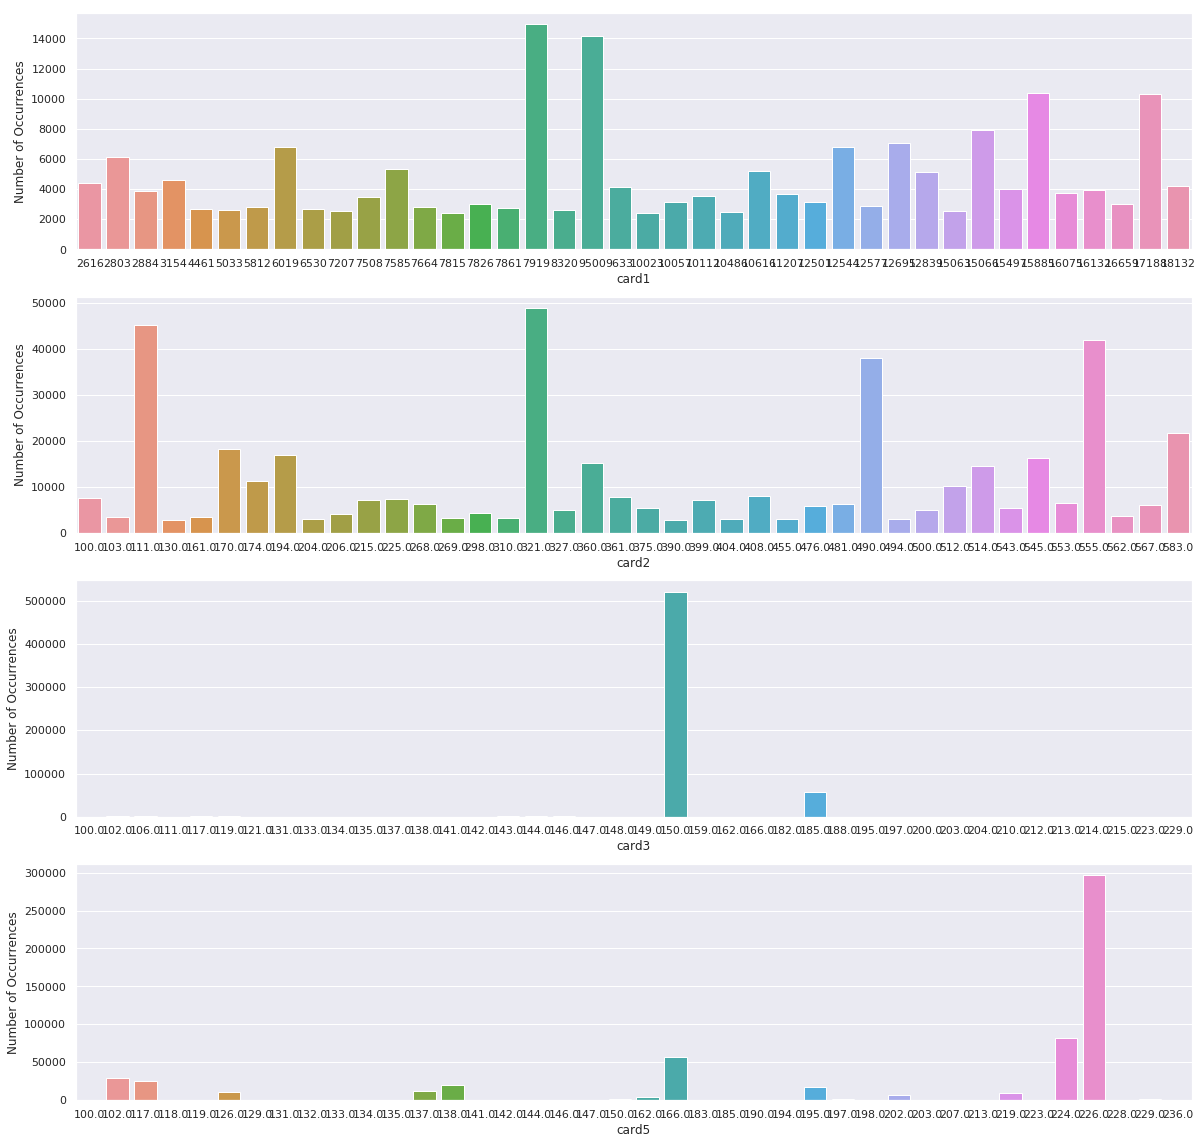

In [29]:
a4_dims = (20, 20)
fig, axs = plt.subplots(4,1, figsize=a4_dims, squeeze=False)
card_list = ['card1','card2','card3','card5']
co = 0

for r in range(0,4):
    for c in range(0, 1): 
        feature_count = train[card_list[co]].value_counts().reset_index()
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        ax = sns.barplot(x='index',y=card_list[co],data=feature_count,errwidth=12,capsize=10,ax=axs[r][c])
        ax.set_xlabel(card_list[co])
        ax.set_ylabel('Number of Occurrences')
        co += 1


print("This column has high number of categoricals to print so it will be very slow")

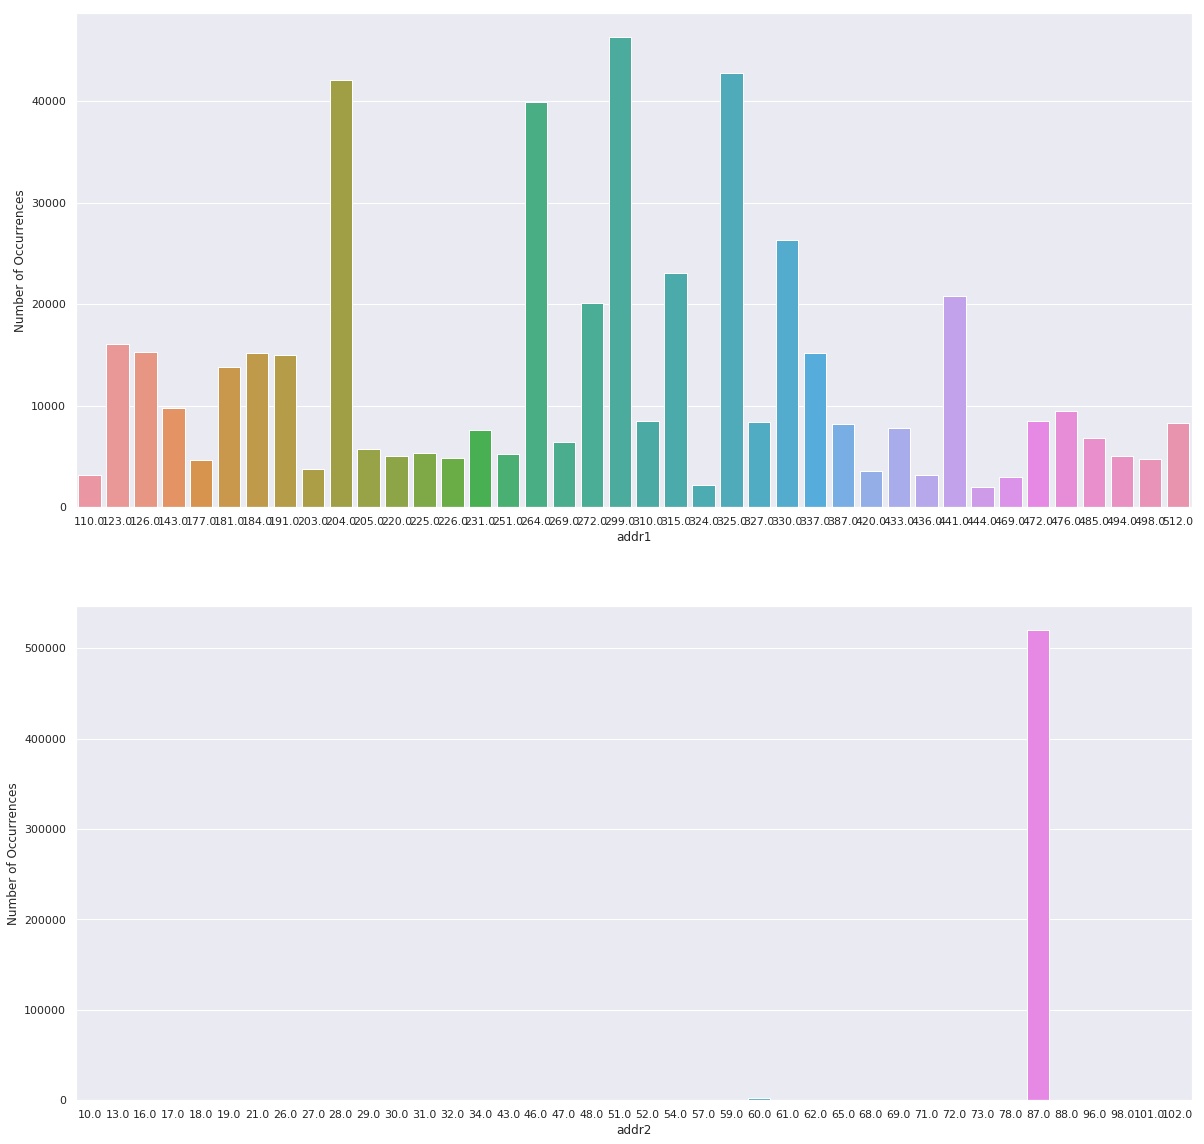

In [30]:
# addr: address addr1, addr2- categorical variable
a4_dims = (20, 20)
fig, axs = plt.subplots(2,1, figsize=a4_dims, squeeze=False)
addr_list = ['addr1','addr2']
co = 0

for r in range(0,2):
    for c in range(0, 1): 
        feature_count = train[addr_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=addr_list[co],data=feature_count,errwidth=12,capsize=10,ax=axs[r][c])
        ax.set_xlabel(addr_list[co])
        ax.set_ylabel('Number of Occurrences')
        co += 1

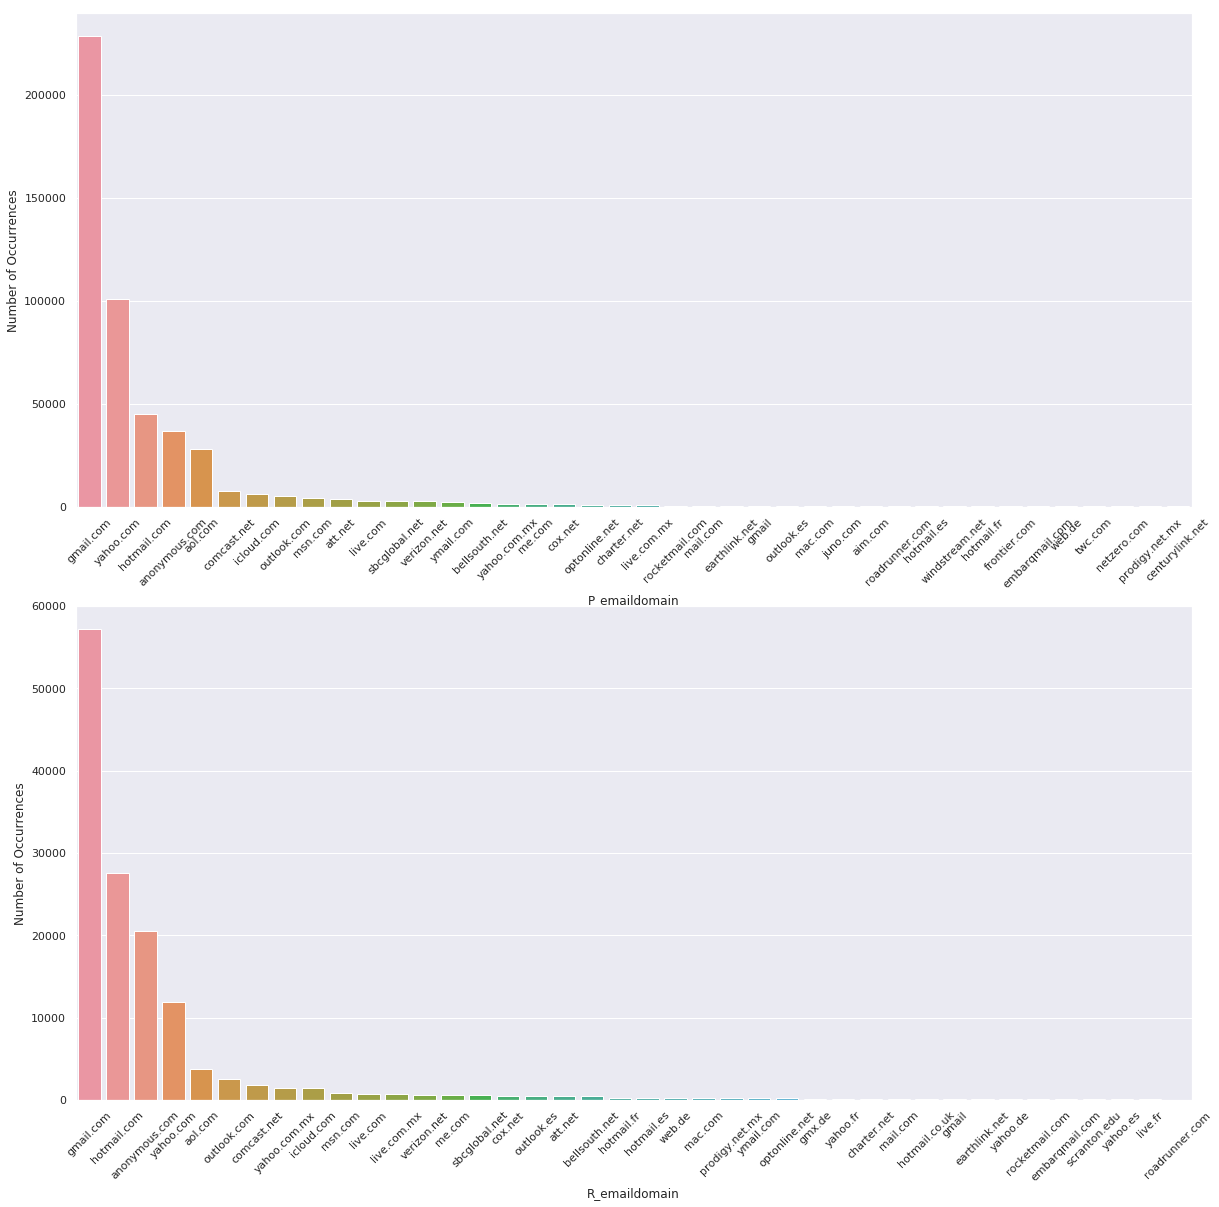

In [32]:
# dist: distance is numerical we can analyze it later
#P_ and (R__) emaildomain: purchaser and recipient email domain its categorical
#print(train['P_emaildomain'].value_counts())
a4_dims = (20, 20)
fig, axs = plt.subplots(2,1, figsize=a4_dims, squeeze=False)
addr_list = ['P_emaildomain','R_emaildomain']
co = 0

for r in range(0,2):
    for c in range(0, 1): 
        feature_count = train[addr_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=addr_list[co],data=feature_count,errwidth=12,capsize=10,ax=axs[r][c])
        ax.set_xlabel(addr_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co += 1

#in both this case the domain name like .eu and .in are different but they should be same try to preprocess it 
# we can split the given one by '.' and take the fisrt part for the correct mail names

In [33]:
m_list = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
# check they are caetgorical or not
for col in m_list:
    print("For the " + str(col))
    print(train[col].value_counts())
# expect M4 all other are T/F

For the M1
T    319415
F        25
Name: M1, dtype: int64
For the M2
T    285468
F     33972
Name: M2, dtype: int64
For the M3
T    251731
F     67709
Name: M3, dtype: int64
For the M4
M0    196405
M2     59865
M1     52826
Name: M4, dtype: int64
For the M5
F    132491
T    107567
Name: M5, dtype: int64
For the M6
F    227856
T    193324
Name: M6, dtype: int64
For the M7
F    211374
T     32901
Name: M7, dtype: int64
For the M8
F    155251
T     89037
Name: M8, dtype: int64
For the M9
T    205656
F     38632
Name: M9, dtype: int64


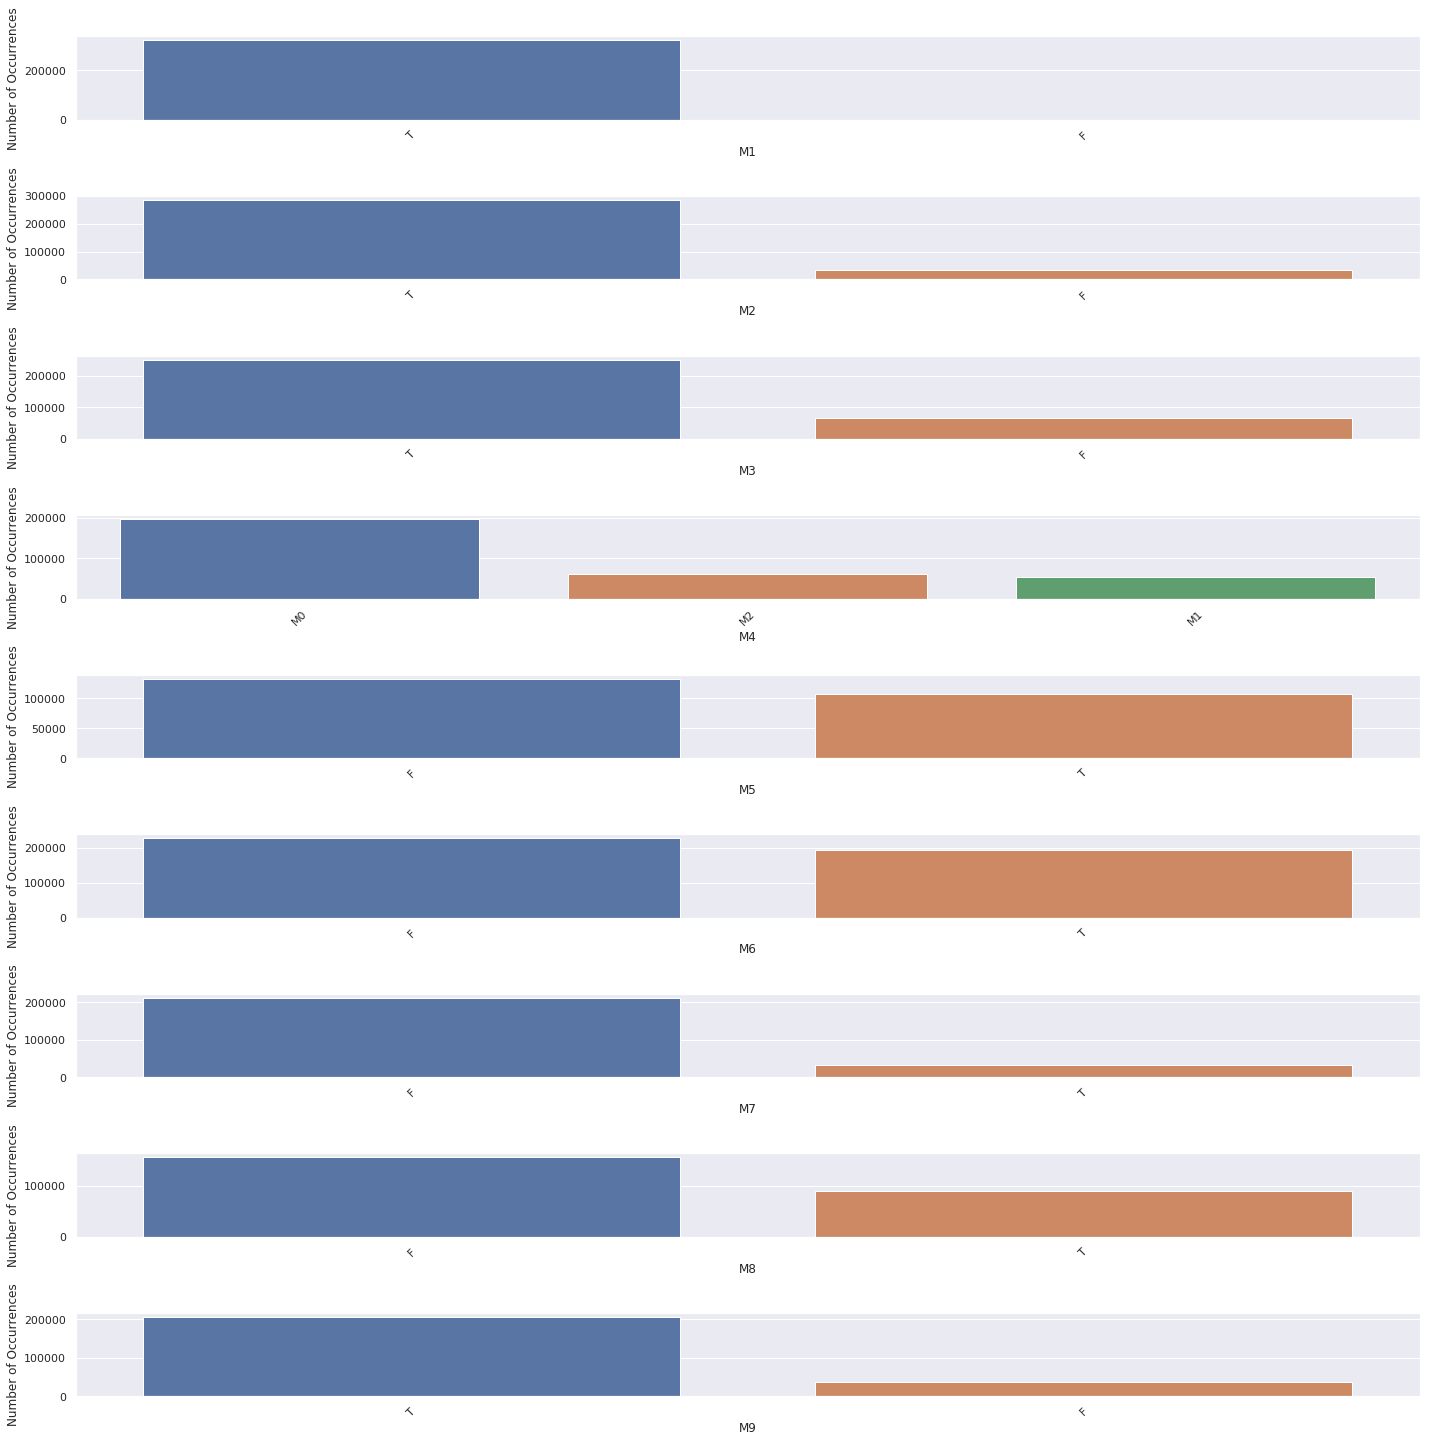

In [34]:
# M1 - M9 categorical variable that need to analyze
# the values are match, such as names on card and address, etc.
a4_dims = (20, 20)
fig, axs = plt.subplots(9,1, figsize=a4_dims, squeeze=False)
co = 0
m_list = ['M1','M2','M3','M4','M5','M6','M7','M8','M9']
for r in range(0,9):
    for c in range(0, 1): 
        feature_count = train[m_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=m_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(m_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co += 1
plt.subplots_adjust(hspace = 0.2)
plt.tight_layout()
# I think no need of preprocess for this M1-M9 set of features.

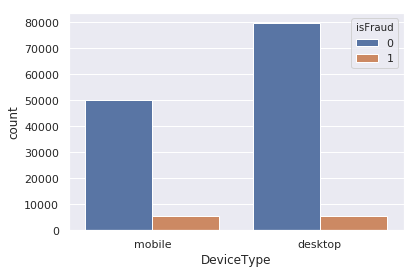

In [35]:
#DeviceType
#train['DeviceType'].value_counts() # only two types # we can check where we get more isFraud 
sns.countplot(x='DeviceType',hue='isFraud',data=train)
# we have more isFraud  in desktop

[Text(0, 0, 'Windows'),
 Text(0, 0, 'iOS Device'),
 Text(0, 0, 'MacOS'),
 Text(0, 0, 'Trident/7.0'),
 Text(0, 0, 'rv:11.0'),
 Text(0, 0, 'rv:57.0'),
 Text(0, 0, 'SM-J700M Build/MMB29K'),
 Text(0, 0, 'SM-G610M Build/MMB29K'),
 Text(0, 0, 'SM-G531H Build/LMY48B'),
 Text(0, 0, 'rv:59.0'),
 Text(0, 0, 'SM-G935F Build/NRD90M'),
 Text(0, 0, 'SM-G955U Build/NRD90M'),
 Text(0, 0, 'SM-G532M Build/MMB29T'),
 Text(0, 0, 'ALE-L23 Build/HuaweiALE-L23'),
 Text(0, 0, 'SM-G950U Build/NRD90M'),
 Text(0, 0, 'SM-G930V Build/NRD90M'),
 Text(0, 0, 'rv:58.0'),
 Text(0, 0, 'rv:52.0'),
 Text(0, 0, 'SAMSUNG'),
 Text(0, 0, 'SM-G950F Build/NRD90M'),
 Text(0, 0, 'Moto G (4) Build/NPJ25.93-14.7'),
 Text(0, 0, 'SM-N950U Build/NMF26X'),
 Text(0, 0, 'SM-A300H Build/LRX22G'),
 Text(0, 0, 'hi6210sft Build/MRA58K'),
 Text(0, 0, 'SM-J730GM Build/NRD90M'),
 Text(0, 0, 'SM-G570M Build/MMB29K'),
 Text(0, 0, 'rv:48.0'),
 Text(0, 0, 'CAM-L03 Build/HUAWEICAM-L03'),
 Text(0, 0, 'SM-J320M Build/LMY47V'),
 Text(0, 0, 'LG-M700 Bui

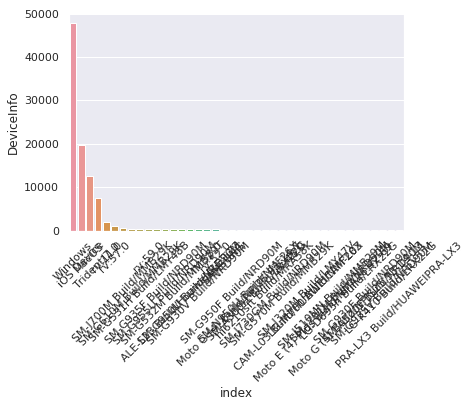

In [36]:
#Deviceinfo
feature_count = train['DeviceInfo'].value_counts().reset_index()
feature_count.sort_values('DeviceInfo')
feature_count = feature_count.iloc[:40,]
#print(feature_count)
ax = sns.barplot(x="index", y="DeviceInfo", data=feature_count,errwidth=12,capsize=100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# we have more isFraud  in desktop

In [37]:
#id12 - id38 we need to analyze this part its categorical variable
id_list = []
for i in range(12,39):
    id_list.append('id_'+str(i))
print(id_list)

['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']


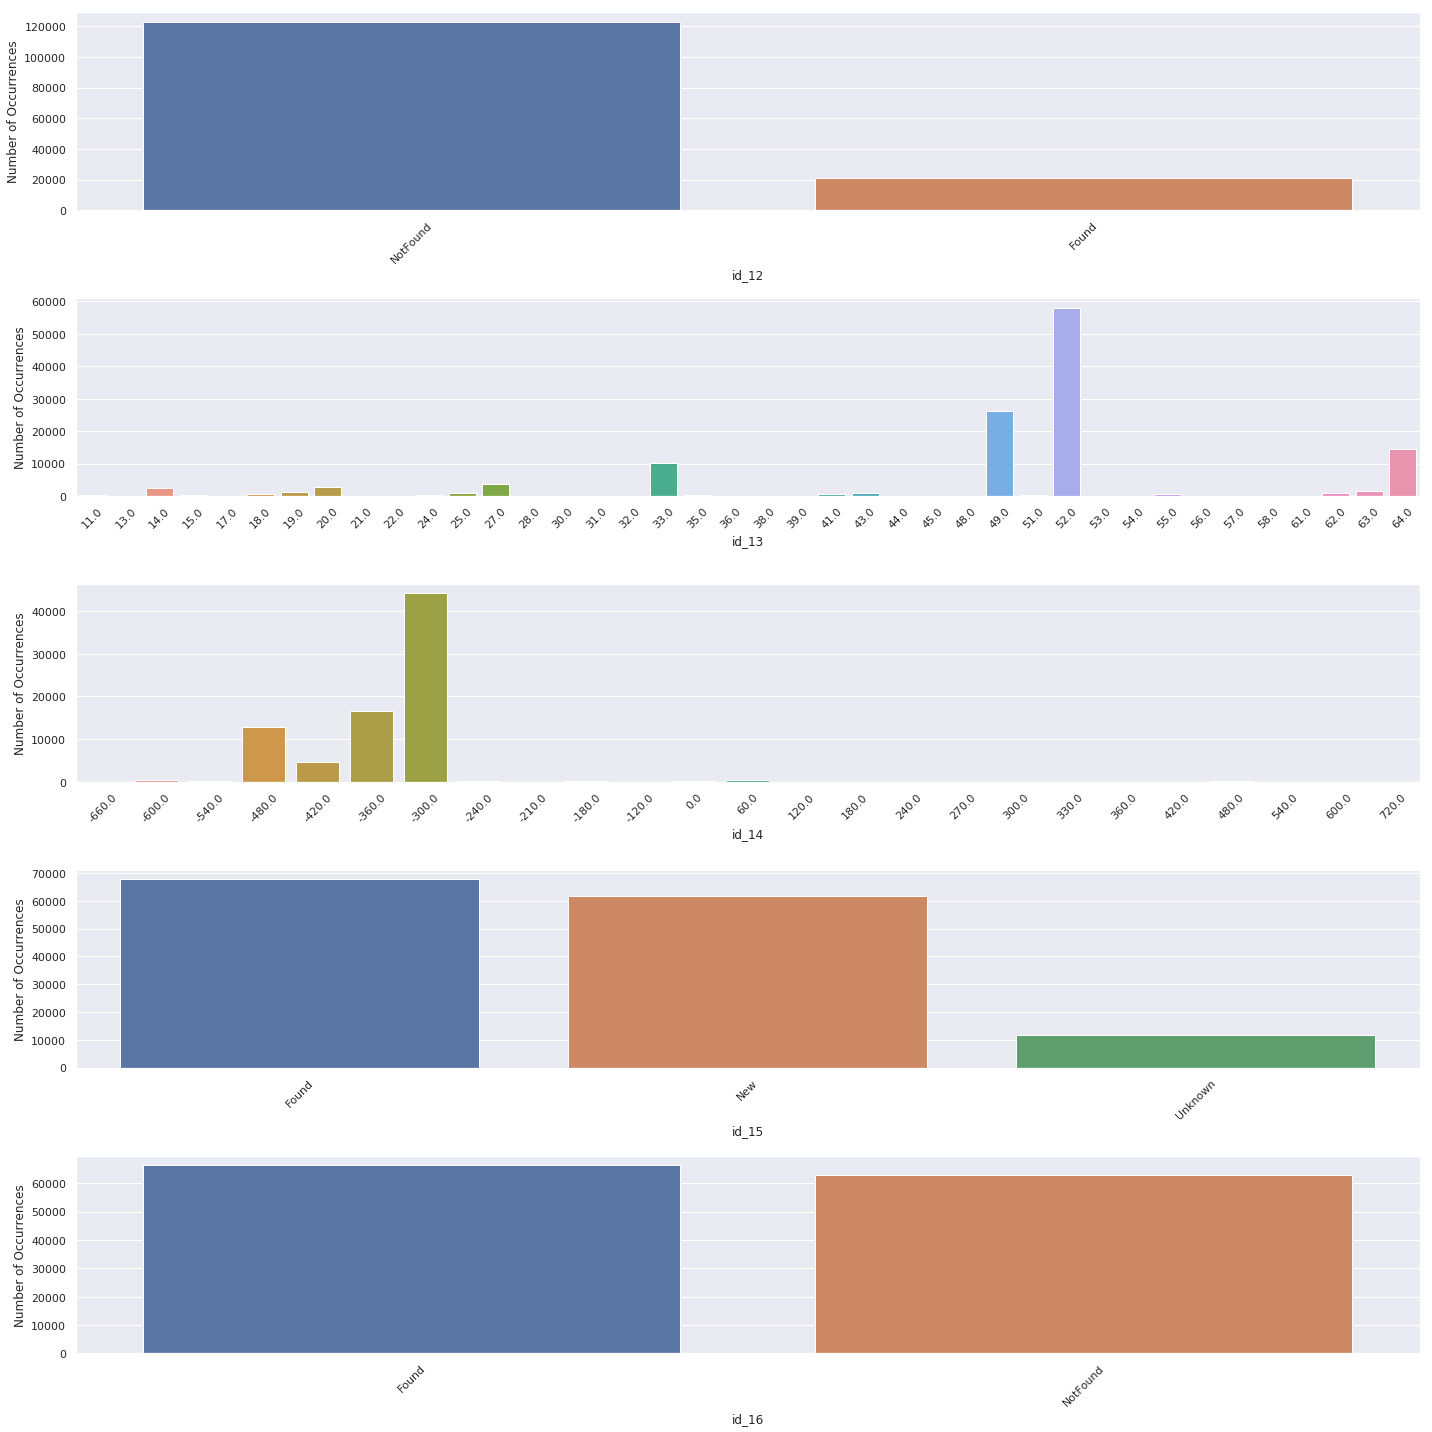

In [38]:
#iterate the id_list and visualize it
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co = 0

for r in range(0,5):
    for c in range(0, 1): 
        feature_count = train[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co += 1

plt.tight_layout()
#id_12 - found/not_found
#id_13- many fields are there
#id_14- many fields are there
#id_15- found/new/unknown
#id_16-found/not_found

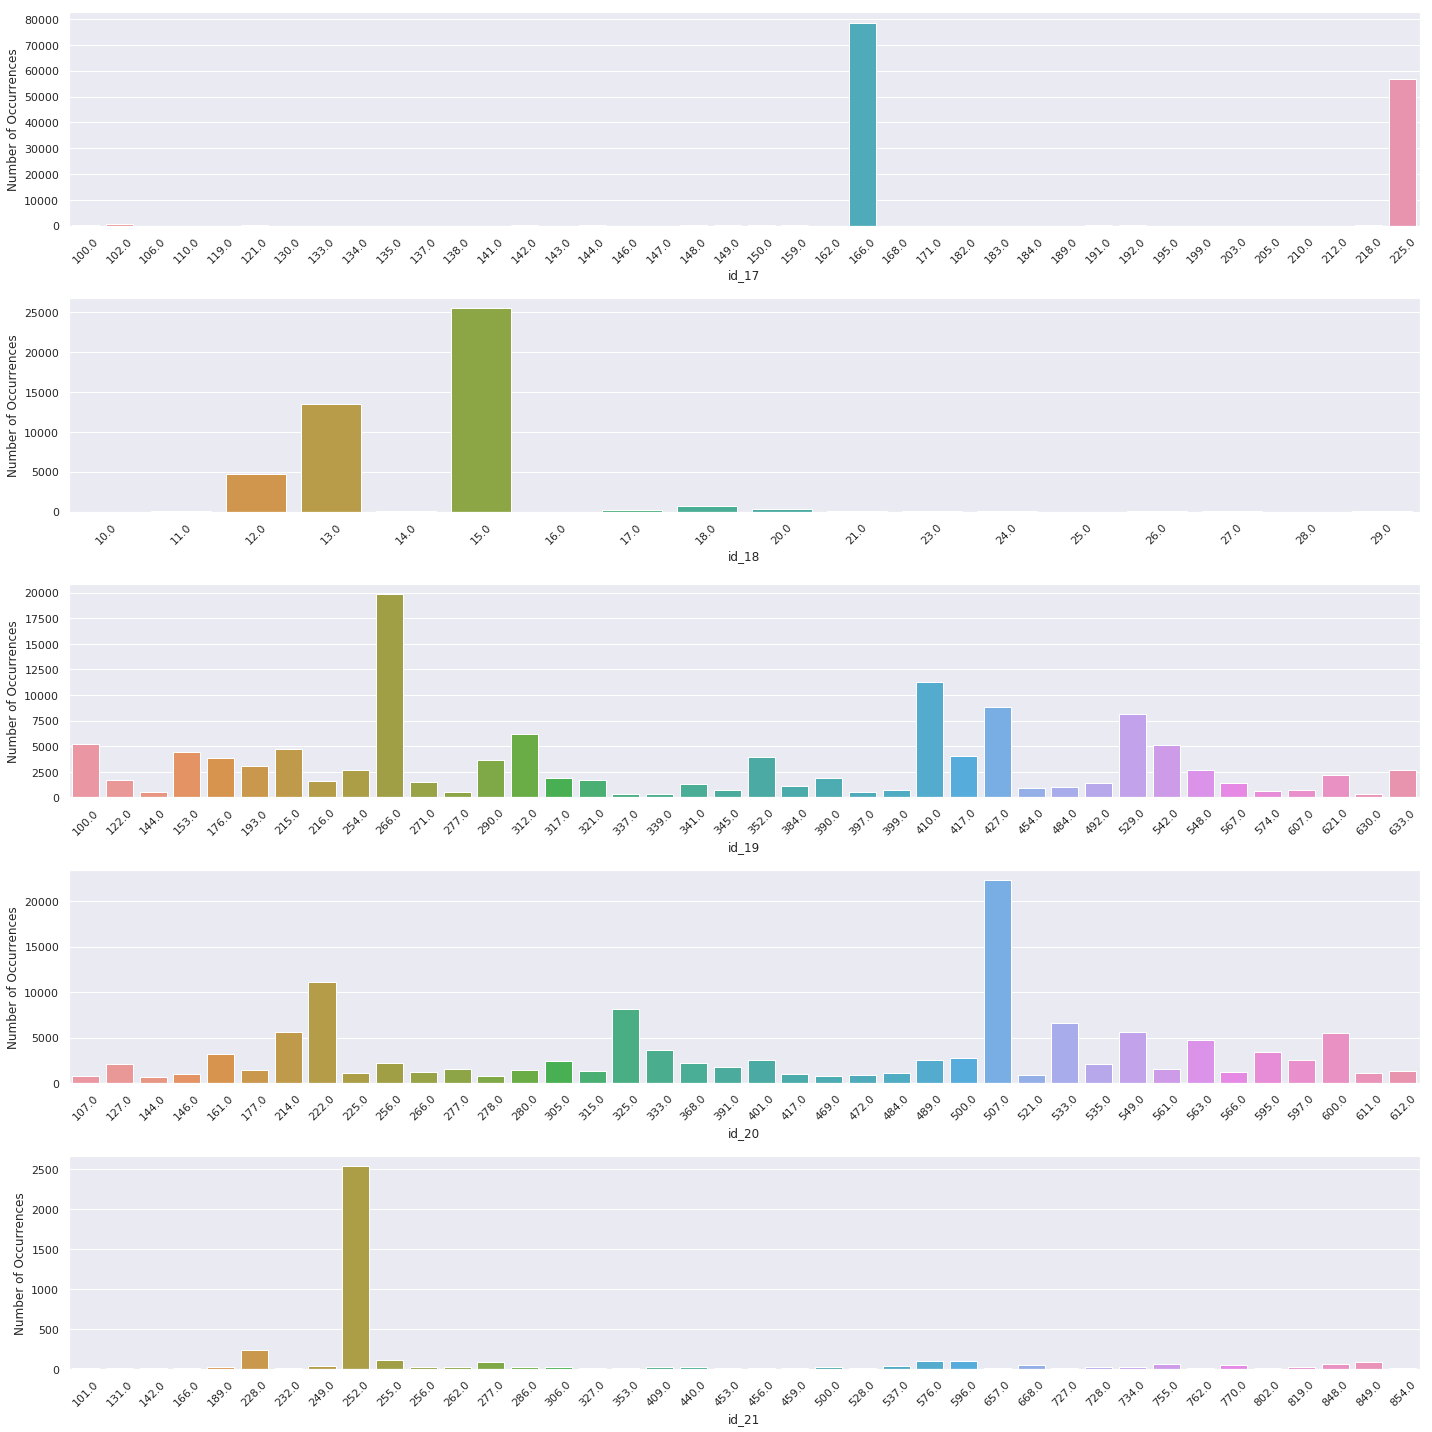

In [39]:
#next 5 features
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co = 5

for r in range(0,5):
    for c in range(0, 1): 
        feature_count = train[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co += 1

plt.tight_layout()

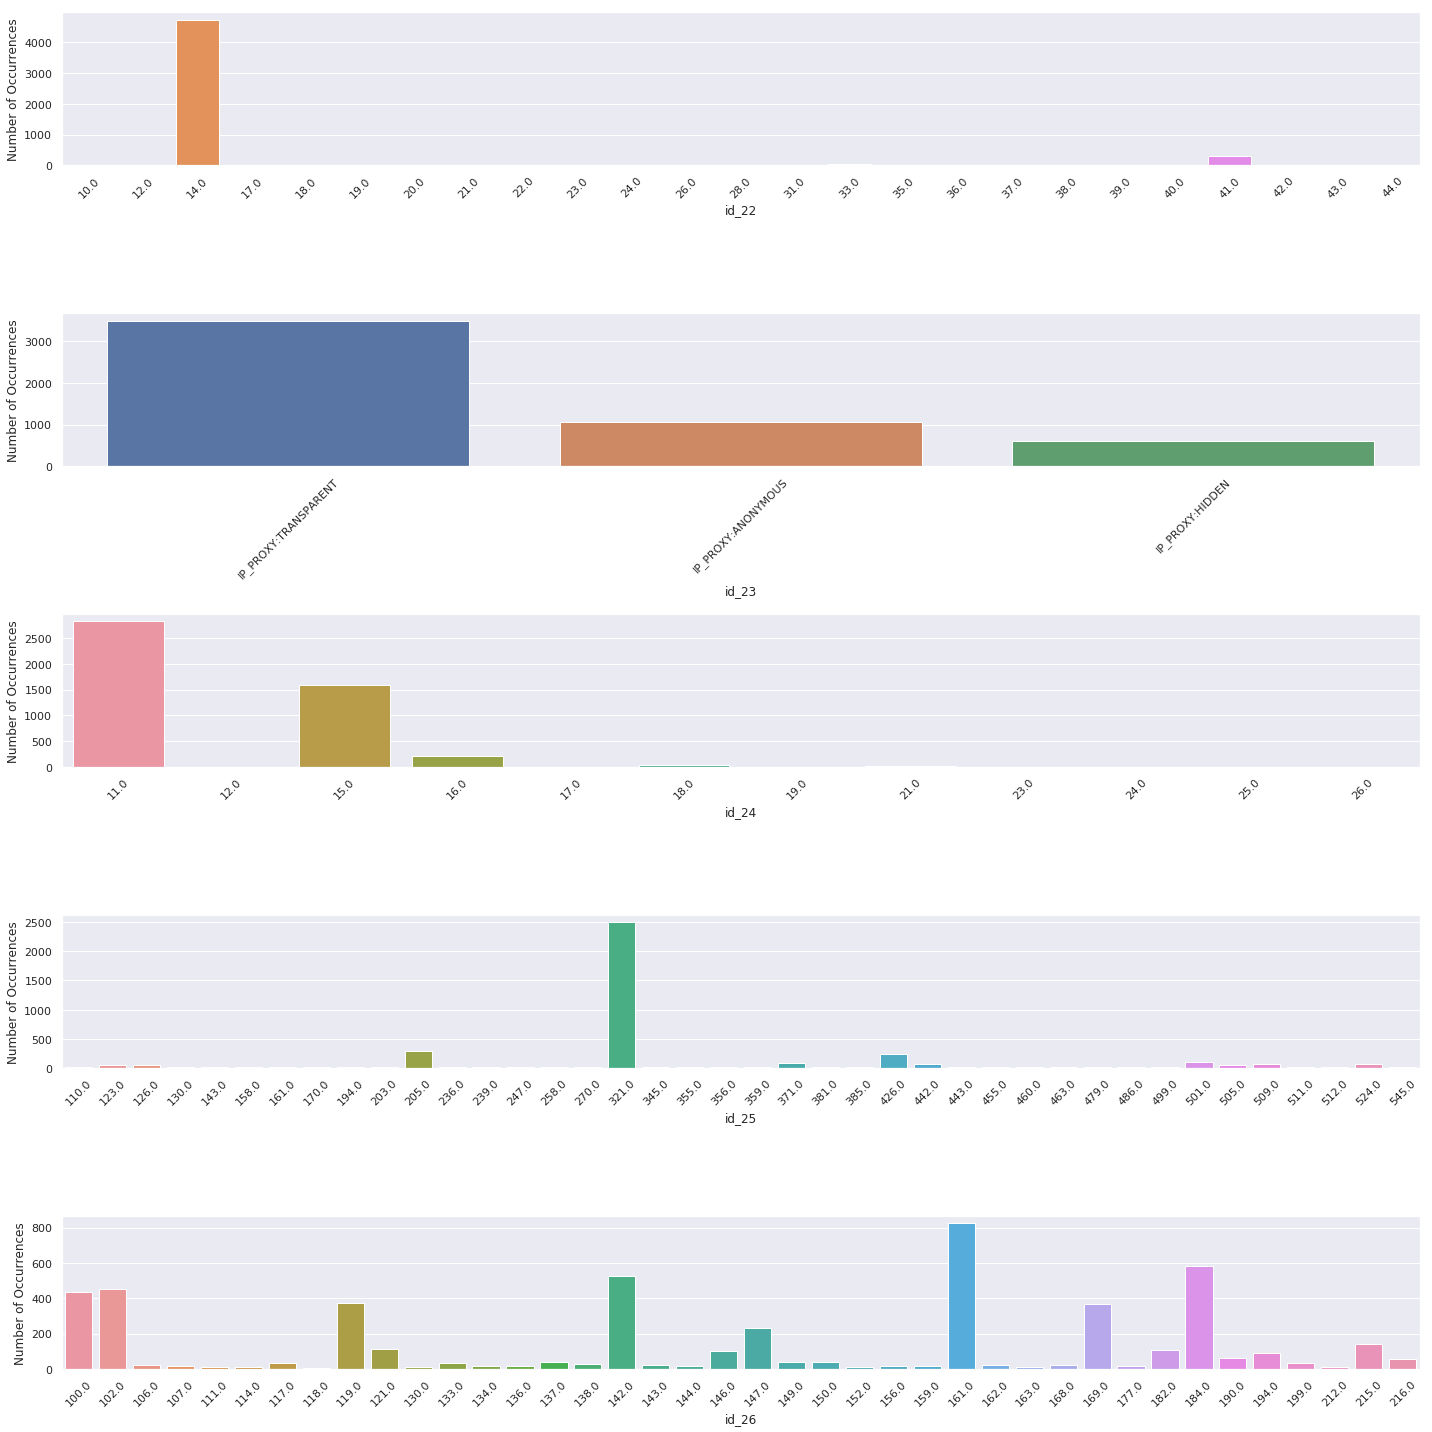

In [40]:
#next 5 features
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co = 10

for r in range(0,5):
    for c in range(0, 1): 
        feature_count = train[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co += 1

plt.tight_layout()
#id_23-proxy-transparent/anonymous/hidden

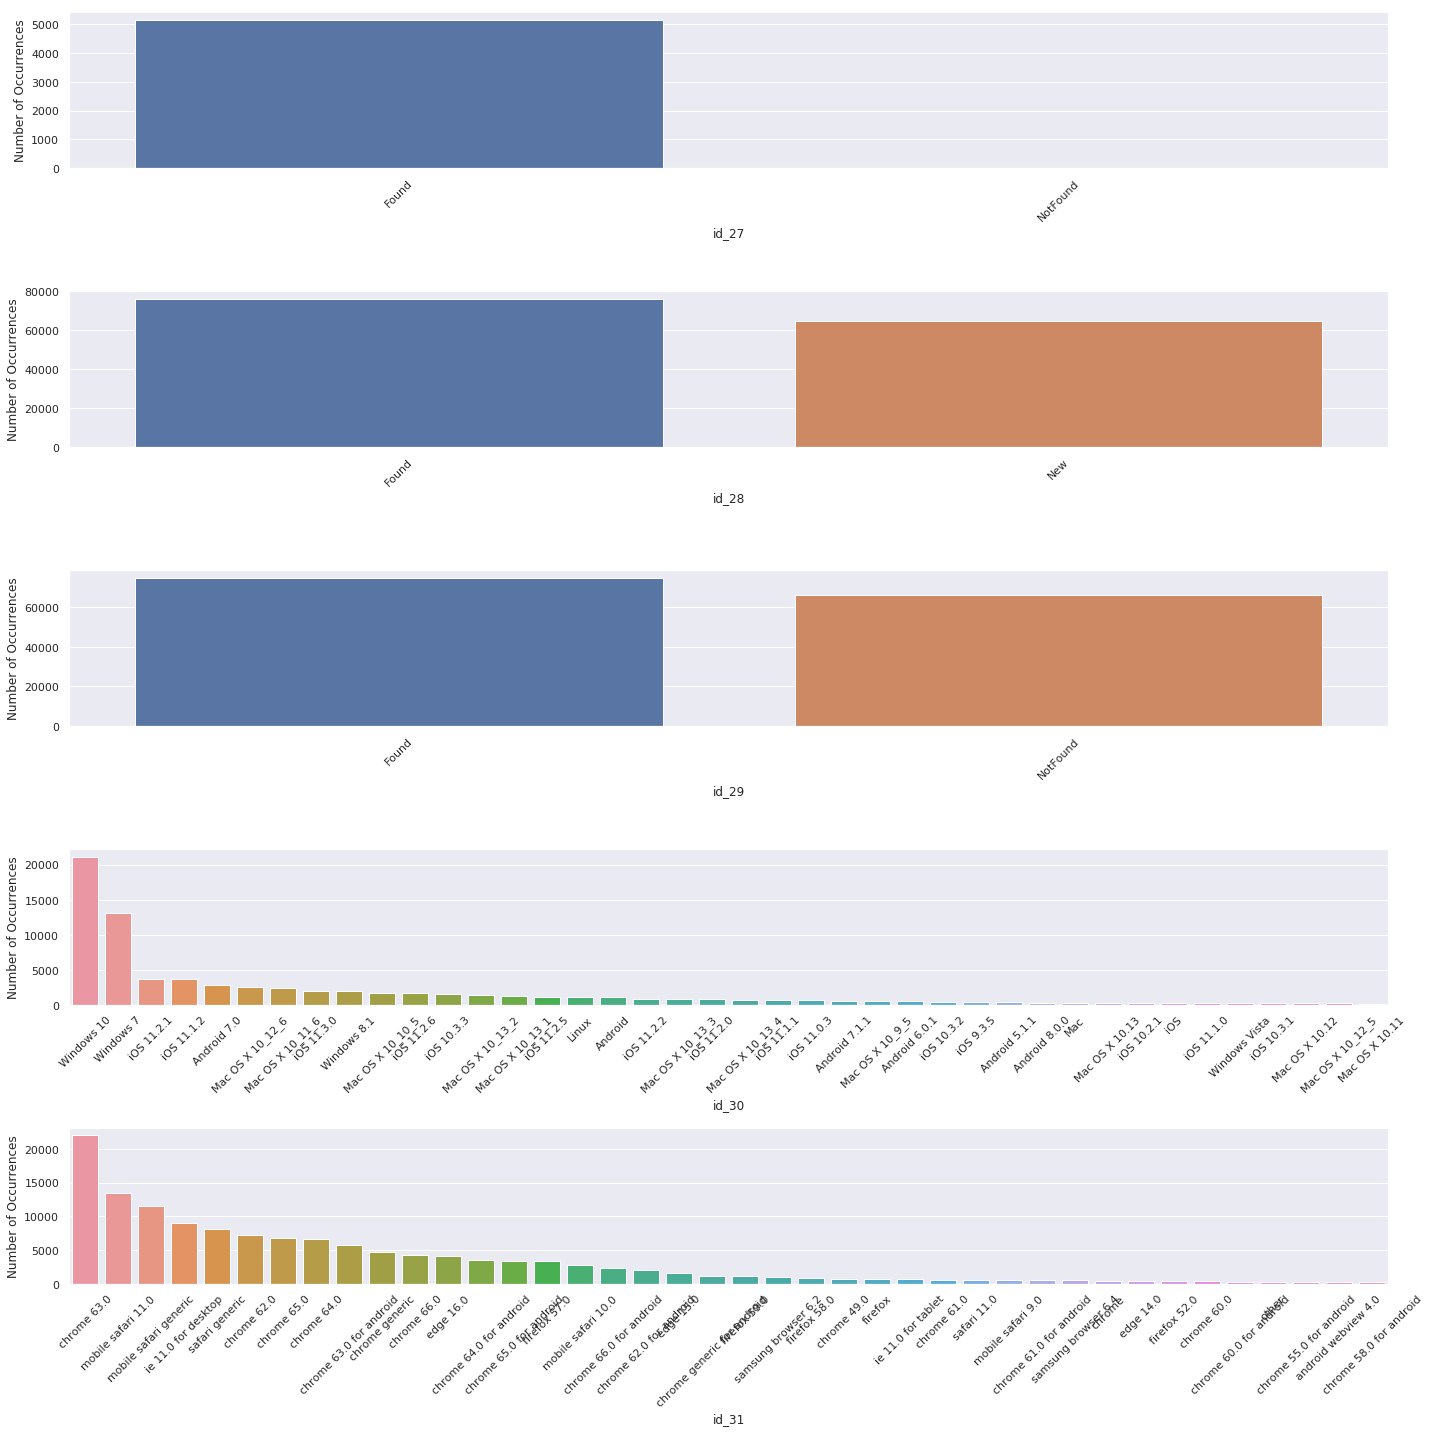

In [41]:
#next 5 features
a4_dims = (20, 20)
fig, axs = plt.subplots(5,1, figsize=a4_dims, squeeze=False)

co = 15

for r in range(0,5):
    for c in range(0, 1): 
        feature_count = train[id_list[co]].value_counts().reset_index()
       # feature_count= feature_count.sort_values([addr_list[co]])
        feature_count = feature_count.iloc[:40,]
        #print(len(feature_count.iloc[:40,]))
        
        ax = sns.barplot(x='index',y=id_list[co],data=feature_count,errwidth=12,capsize=100,ax=axs[r][c])
       
        ax.set_xlabel(id_list[co])
        ax.set_ylabel('Number of Occurrences')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        co += 1

plt.tight_layout()
#id_27/_29 -found/not-found
#id_28-found/new

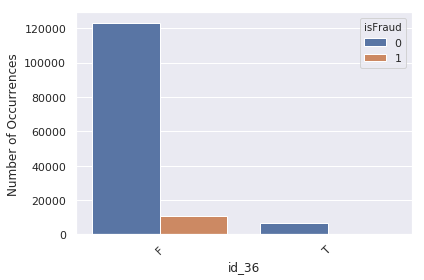

In [42]:
# you can check the some of the important parameters here
someFeature_list = ['id_36','id_35','id_34','id_28','id_29','id_12','id_15','id_16']
a4_dims = (20, 20)
co = 0
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

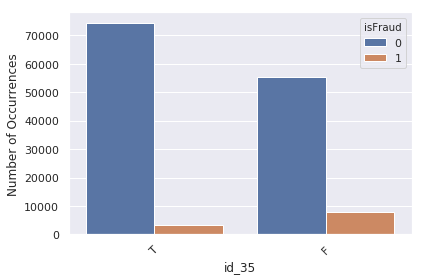

In [43]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

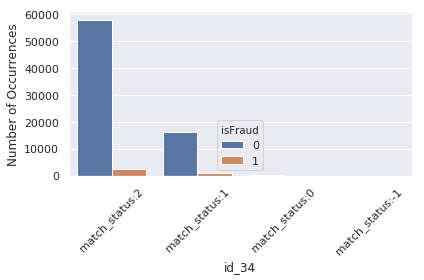

In [44]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

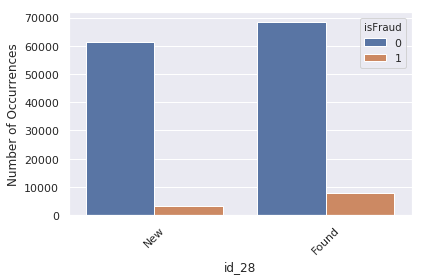

In [45]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

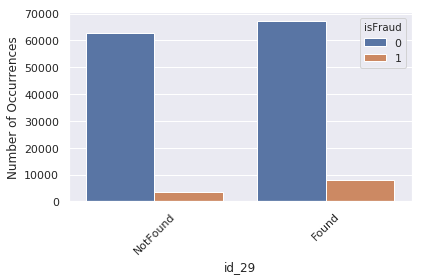

In [46]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

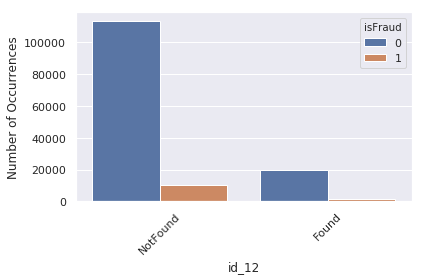

In [47]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

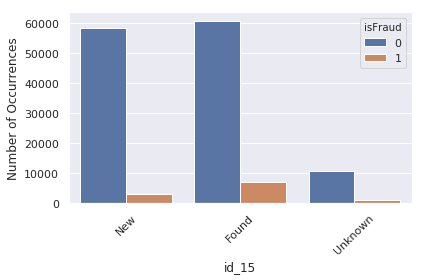

In [48]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

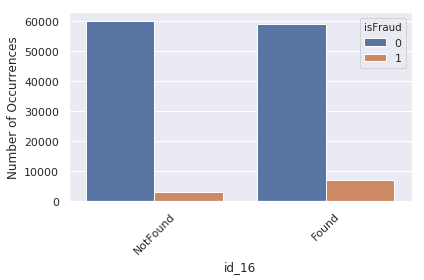

In [49]:
ax = sns.countplot(x=someFeature_list[co],hue='isFraud',data=train)
ax.set_xlabel(someFeature_list[co])
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
co += 1
plt.tight_layout()

In [50]:
print(addr_list)
# when you do one hot encoding please add both test and train both may have different one
for col in addr_list:
    train[col] = (train[col].str.split(".",expand=True)[0])
    test[col] = (test[col].str.split(".",expand=True)[0])
# now we are done with mails so we do some feature engineering

['P_emaildomain', 'R_emaildomain']


In [0]:
#Feature Engineering 
# first we can try to use card features
for col in ['card1','card2','card3','card4','card5','card6']:
    # we are just taking a mean for each group and diving it with the each group Transaction amount to get more information
    # and also std for each group 
    train['Transactionamt_mean_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('mean'))
    train['Transactionamt_std_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('std'))
    test['Transactionamt_mean_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('mean'))
    test['Transactionamt_std_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('std'))
#feature Engineering only for Cards alone
# we also need to check device info and device type,id_30,id_31

In [0]:
#Let's try to do feature Enginnering based on ProductCD because it has only 4 levels
# and also for P_emaildomain ,R_emaildomain,DeviceType
#DeviceInfo,id_15,id_23,id_30,id_31,id_34
#you guys can do according to your understanding
for col in ['ProductCD', 'P_emaildomain','R_emaildomain','DeviceType','DeviceInfo','id_15','id_23','id_30','id_31','id_34']:
    train['Transactionamt_mean_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('mean'))
    train['Transactionamt_std_'+str(col)]=(train['TransactionAmt']/train.groupby(col)['TransactionAmt'].transform('std'))
    test['Transactionamt_mean_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('mean'))
    test['Transactionamt_std_'+str(col)]=(test['TransactionAmt']/test.groupby(col)['TransactionAmt'].transform('std'))
# there will be lot of NAN in our columns 

In [53]:
# now we can preprocess our data
print("Total number of columns after Feture Engineering:",len(train.columns)) #466
# now we want to drop the unwanted columns
print(total_drop_cols)
#train=train.drop(drop)
for col in total_drop_cols:
    del train[col]
    del test[col]
print("Final number of columns after Feature Engineering:",len(train.columns)) # 384

Total number of columns after Feture Engineering: 466
['V123', 'V124', 'V297', 'V105', 'V112', 'id_07', 'C3', 'V113', 'D7', 'V137', 'V98', 'V320', 'id_24', 'V300', 'V66', 'V286', 'V316', 'V23', 'V318', 'V14', 'V114', 'V107', 'id_25', 'dist2', 'V121', 'V299', 'V319', 'V296', 'V65', 'V116', 'V321', 'V293', 'V104', 'V25', 'V301', 'V103', 'V119', 'V67', 'V88', 'V89', 'id_23', 'V290', 'V135', 'V111', 'V108', 'V120', 'V305', 'id_18', 'V26', 'V136', 'V68', 'V117', 'V129', 'V295', 'V298', 'V86', 'V102', 'V77', 'V106', 'V125', 'id_27', 'V118', 'id_22', 'V122', 'V115', 'V309', 'V24', 'V109', 'V55', 'V311', 'V110', 'V27', 'id_26', 'id_21', 'V132', 'V28', 'V133', 'V101', 'V281', 'id_08', 'V134', 'V284']
Final number of columns after Feature Engineering: 384


In [0]:
#now we can do label encoding for categorical variable
# we can do one hot encoding but it will increase our dimension so its problem
# so we can try label encoding or any other encoding like frequency encoding .etc
# i am going to try label encoding
from sklearn  import preprocessing
for col in train.columns:
    if train[col].dtype=='object' :
      #  print("label encoding",col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[col].values) + list(test[col].values))
        train[col] =lbl.transform(list(train[col].values))
        test[col]=lbl.transform(list(test[col].values))

In [0]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
train = clean_inf_nan(train)
test = clean_inf_nan(test ) # replace all nan,inf,-inf to nan so it will be easy to replace
for i in train.columns:
    train[i].fillna(train[i].median(),inplace=True) # fill with median because mean may be affect by outliers.
#X.isna().sum().sum()
for i in test.columns:
    test[i].fillna(test[i].median(),inplace=True)

In [56]:
print("Number of Na's in train",train.isna().sum().sum())
print("Number of Na's in test",test.isna().sum().sum())

Number of Na's in train 0
Number of Na's in test 0


In [0]:
# now we an split the data and train our model
X = train.drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train['isFraud']
#X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)
X_test = test.drop(['TransactionDT', 'TransactionID'], axis=1)
#del train
test = test[['TransactionID']]
# TransactionDT is skewed so try to apply the transformation for better results

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#train and test split
#from sklearn.model_selection import train_test_split
#xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [59]:
submission = pd.DataFrame()
submission['TransactionID']=test['TransactionID']
submission['isFraud'] = 0
import xgboost as xgb
from sklearn.metrics import roc_auc_score
print(submission.head(5))

   TransactionID  isFraud
0        3663549        0
1        3663550        0
2        3663551        0
3        3663552        0
4        3663553        0


In [0]:
# we can try to fit the base model 
# we can try logistic regression
from sklearn.linear_model import LogisticRegressionCV
#clf = LogisticRegressionCV(cv=5, random_state=0).fit(xTrain, yTrain)

In [0]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(X, y)

In [0]:
train_res = clf.predict_proba(X)

In [0]:
test_res = clf.predict_proba(X_test)

In [64]:
train_res = pd.DataFrame(train_res)
train_res.head()

,0,1
0,0.967460,0.032540
1,0.958172,0.041828
2,0.974024,0.025976
3,0.966884,0.033116
4,0.950816,0.049184


In [0]:
train_val = pd.concat([X, train_res.iloc[0:train_res.shape[0],1]], axis=1)

In [0]:
train_val = pd.concat([train_val,y],axis=1)

In [67]:
test_res = pd.DataFrame(test_res)
test_res.head()

,0,1
0,0.990473,0.009527
1,0.988658,0.011342
2,0.977039,0.022961
3,0.977111,0.022889
4,0.968372,0.031628


In [0]:
test_val = pd.concat([X_test,test_res.iloc[0:test_res.shape[0],1]],axis=1)

In [69]:
print(test_val.shape)
print(train_val.shape)

(506691, 382)
(590540, 383)


In [70]:
submission = pd.DataFrame()
submission = test
submission['isFraud'] = test_val[1]
submission.head(5)

,TransactionID,isFraud
0,3663549,0.009527
1,3663550,0.011342
2,3663551,0.022961
3,3663552,0.022889
4,3663553,0.031628
